# GRU

Gated Recurrent Unit（更新ゲート）と呼ばれます。

深層学習（ディープラーニング）の分野において用いられる再帰型ニューラルネットワーク（RNN）の1種です。

LSTMには、「入力ゲート」「忘却ゲート」と呼ばれるものがあります。GRUでは、この2つのゲートを組み合わせて「更新ゲート」という風に定義しています。下図の概略図にもある通り、LSTMより簡素な作りになっています。

学習速度に関しては、簡素になった分早くなります。

精度に関しては、一見LSTMより落ちるように見えますが、一般的には劣るが、単純なデータセットや、音声モデリングなどの分野では、LSTMと類似した性能を示すことが知られている。

その他の特徴に関しては、LSTMより勾配消失が起きにくいことで知られている。

## LSTMの内部

<img src="./images/LSTM_inner.png" width="60%" style="position:relative;left:-20%;">


## GRUの内部
<img src="./images/GRU_inner.png" width="60%" style="position:relative;left:-20%;">

引用：https://qiita.com/KojiOhki/items/89cd7b69a8a6239d67ca

In [1]:
# ライブラリの読み込みと各種設定
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
# グラフの日本語設定
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
plt.rcParams['figure.figsize'] = 20, 5

## データの読み込み

今回使用するデータは、気温の時系列データです。

データ配布元：http://www.data.jma.go.jp/gmd/risk/obsdl/index.php

**まずは、理解を容易にするため、気温データのみを用います**

In [2]:
weather_df = pd.read_csv("./data/weather.csv", index_col='年月日', encoding="shift-jis")

In [3]:
weather_df

,平均気温(℃),降水量の合計(mm),平均風速(m/s),日照時間(時間),平均現地気圧(hPa)
年月日,,,,,
2015/1/1,3.7,0.0,4.4,1.3,1000.4
2015/1/2,2.7,0.0,2.1,6.0,1007.4
2015/1/3,3.8,0.0,3.0,8.9,1012.0
2015/1/4,4.0,0.0,1.3,6.0,1010.4
2015/1/5,6.9,0.0,2.4,8.9,1014.6
...,...,...,...,...,...
2019/12/28,6.8,0.0,3.5,8.8,1019.9
2019/12/29,7.0,0.0,1.9,8.3,1026.5
2019/12/30,6.7,0.5,1.8,0.0,1021.0


## データの作成

説明変数と目的変数を作っていきます。

説明変数は、時刻(t-p) ~ 時刻(t-1)までの範囲

＊p:単位時間×任意の長さ→どこまで昔のデータを使用したいか

目的変数は、時刻(t)での値

In [4]:
# 説明変数を格納
data_X = []
# 目的変数を格納
data_y = []
# 時数（どこまで過去のデータを考慮したいか）
p = 10
for i in range(len(weather_df)-p):
    data_X.append(weather_df['平均気温(℃)'][i:i+p])
    data_y.append(weather_df['平均気温(℃)'][i+p])
    
data_X = np.array(data_X)
data_y = np.array(data_y)

In [5]:
# 訓練データとテストデータに分けます。
len_train = int(len(data_X)*0.7)

X_train = data_X[:len_train]
X_test = data_X[len_train:]
y_train = data_y[:len_train]
y_test = data_y[len_train:]

print(len(X_train),len(X_test))

1271 546


In [6]:
# 正規化（Normarization）
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
X_train_n = scaler_x.fit_transform(X_train)
X_test_n = scaler_x.transform(X_test) 
scaler_y = MinMaxScaler()
y_train_n = scaler_y.fit_transform(y_train.reshape(len(y_train),1))
y_test_n = scaler_y.transform(y_test.reshape(len(y_test),1)) 

In [7]:
# 現在のデータ形式
print(X_train.shape,X_test.shape)

(1271, 10) (546, 10)


## データ形式の変更

上記で見た通り、（データ数, 説明変数の数）の形式になっていますが、

これを、（データ数, 系列数, 説明変数の数）に変更してやる必要があります。

＊系列数：扱う時系列データの種類数

今回は、「気温」だけ扱うので、系列数＝1で大丈夫ですが、「気温」「湿度」など複数の時系列データを扱う際は、その数に応じた数値を指定してやる必要があります。

In [8]:
X_train_n = np.reshape(X_train_n, (X_train_n.shape[0], 1, X_train_n.shape[1]))
X_test_n = np.reshape(X_test_n, (X_test_n.shape[0], 1, X_test_n.shape[1]))

## モデルの実装

データの準備が整いましたので、モデルを「作成→学習→予測」していきます

In [9]:
from keras.layers import GRU,Dense
from keras import models

Using TensorFlow backend.


In [10]:
# 時数（どこまで過去のデータを考慮したいか）
p = 10

# モデル定義
model = models.Sequential()
model.add(
    GRU(
        100, 
        activation='tanh', 
        input_shape=(1, p)
    )
)
model.add(Dense(1,activation='linear'))

# 学習設定
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# モデルの学習
result = model.fit(
    X_train_n, 
    y_train_n, 
    batch_size=10, 
    epochs=100
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1271/1271 [==============================] - 1s 670us/step - loss: 0.0366
Epoch 2/100
1271/1271 [==============================] - 0s 304us/step - loss: 0.0062
Epoch 3/100
1271/1271 [==============================] - 0s 297us/step - loss: 0.0056
Epoch 4/100
1271/1271 [==============================] - 0s 304us/step - loss: 0.0052
Epoch 5/100
1271/1271 [==============================] - 0s 298us/step - loss: 0.0048
Epoch 6/100
1271/1271 [==============================] - 0s 312us/step - loss: 0.0047
Epoch 7/100
1271/1271 [==============================] - 0s 291us/step - loss: 0.0045
Epoch 8/100
1271/1271 [==============================] - 0s 286us/step - loss: 0.0044
Epoch 9/100
1271/1271 [==============================] - 0s 297us/step - loss: 0.0045
Epoch 10/100
1271/1271 [==============================] - 0s 292us/step - loss: 0.0044
Epoch 11/100
1271/1271 [==============================] - 0s 293us/step - loss: 0.0043
Epoc

1271/1271 [==============================] - 0s 290us/step - loss: 0.0040
Epoch 93/100
1271/1271 [==============================] - 0s 304us/step - loss: 0.0042
Epoch 94/100
1271/1271 [==============================] - 0s 301us/step - loss: 0.0041
Epoch 95/100
1271/1271 [==============================] - 0s 311us/step - loss: 0.0041
Epoch 96/100
1271/1271 [==============================] - 0s 301us/step - loss: 0.0041
Epoch 97/100
1271/1271 [==============================] - 0s 310us/step - loss: 0.0041
Epoch 98/100
1271/1271 [==============================] - 0s 306us/step - loss: 0.0041
Epoch 99/100
1271/1271 [==============================] - 0s 312us/step - loss: 0.0040
Epoch 100/100
1271/1271 [==============================] - 0s 309us/step - loss: 0.0041


In [12]:
# 予測値の算出
y_prediction_n = model.predict(X_test_n)
# 正規化の復元
y_prediction = scaler_y.inverse_transform(y_prediction_n).flatten()

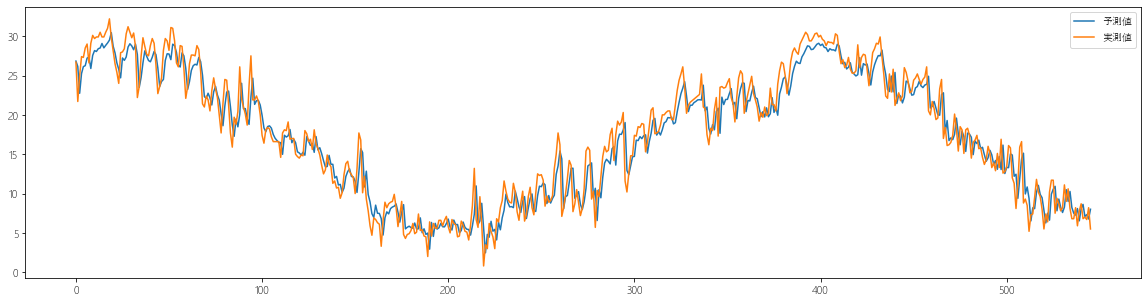

In [13]:
plt.plot(y_prediction, label='予測値')
plt.plot(y_test, label='実測値')
plt.legend()

In [14]:
# 乖離度
print(
    np.mean(
        np.abs(y_prediction-y_test)
        /y_test
    )
)

0.1338402230554396


# 複雑なモデルの実装

前述のモデルは、過去の「気温」のみのデータを用いて、未来の「気温」を予測しましたが、

次は、過去の「気温」「気圧」のみのデータを用いて、未来の「気温」「気圧」を予測してみます。

## データの作成

In [15]:
# 正規化（Normarization）
from sklearn.preprocessing import MinMaxScaler
scaler_x1 = MinMaxScaler()
x1 = scaler_x1.fit_transform(weather_df['平均気温(℃)'].values.reshape(weather_df['平均気温(℃)'].shape[0],1))
scaler_x2 = MinMaxScaler()
x2 = scaler_x2.fit_transform(weather_df['日照時間(時間)'].values.reshape(weather_df['日照時間(時間)'].shape[0],1))

In [16]:
# 説明変数を格納
data_X = []
# 目的変数を格納
data_y = []
# 時数（どこまで過去のデータを考慮したいか）
p = 10
for i in range(len(weather_df)-p):
    data_X.append([x1[i:i+p].flatten(),x2[i:i+p].flatten()])
    data_y.append(x1[i+p])
    
data_X = np.array(data_X)
data_y = np.array(data_y)

In [17]:
# 訓練データとテストデータに分けます。
len_train = int(len(data_X)*0.7)

X_train = data_X[:len_train]
X_test = data_X[len_train:]
y_train = data_y[:len_train]
y_test = data_y[len_train:]

print(len(X_train),len(X_test))

1271 546


In [18]:
# 時数（どこまで過去のデータを考慮したいか）
p = 10

# モデル定義
model = models.Sequential()
model.add(
    GRU(
        100, 
        activation='tanh', 
        input_shape=(2, p)
    )
)
model.add(Dense(1,activation='linear'))

# 学習設定
model.compile(
    loss='mean_squared_error', 
    optimizer='adam', 
)

In [19]:
# モデルの学習
result = model.fit(
    X_train, 
    y_train, 
    batch_size=10, 
    epochs=100
)

Epoch 1/100
1271/1271 [==============================] - 1s 625us/step - loss: 0.0209
Epoch 2/100
1271/1271 [==============================] - 0s 384us/step - loss: 0.0055
Epoch 3/100
1271/1271 [==============================] - 0s 392us/step - loss: 0.0050
Epoch 4/100
1271/1271 [==============================] - 0s 389us/step - loss: 0.0049
Epoch 5/100
1271/1271 [==============================] - 0s 385us/step - loss: 0.0045
Epoch 6/100
1271/1271 [==============================] - 0s 393us/step - loss: 0.0045
Epoch 7/100
1271/1271 [==============================] - 1s 397us/step - loss: 0.0045
Epoch 8/100
1271/1271 [==============================] - 0s 385us/step - loss: 0.0044
Epoch 9/100
1271/1271 [==============================] - 1s 395us/step - loss: 0.0043
Epoch 10/100
1271/1271 [==============================] - 0s 382us/step - loss: 0.0042
Epoch 11/100
1271/1271 [==============================] - 0s 392us/step - loss: 0.0046
Epoch 12/100
1271/1271 [============================

1271/1271 [==============================] - 0s 370us/step - loss: 0.0034
Epoch 96/100
1271/1271 [==============================] - 0s 367us/step - loss: 0.0035
Epoch 97/100
1271/1271 [==============================] - 0s 367us/step - loss: 0.0034
Epoch 98/100
1271/1271 [==============================] - 0s 381us/step - loss: 0.0036
Epoch 99/100
1271/1271 [==============================] - 0s 362us/step - loss: 0.0035
Epoch 100/100
1271/1271 [==============================] - 0s 375us/step - loss: 0.0035


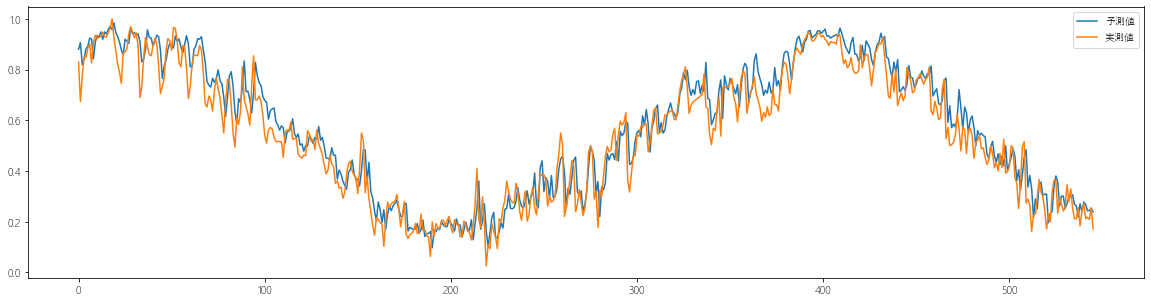

In [20]:
# 予測
y_prediction = model.predict(X_test).flatten()

plt.plot(y_prediction, label='予測値')
plt.plot(y_test, label='実測値')
plt.legend()

In [21]:
# 乖離度
print(
    np.mean(
        np.abs(y_prediction-y_test.flatten())
        /y_test
    )
)

0.13759191190195122
